<a href="https://colab.research.google.com/github/SanBartolome/IA-diploma-course-2021/blob/main/ProblemaMochila_Desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizacion Industrial con Computacion Evolutiva
<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>

Dr. Edwin Villanueva (ervillanueva@pucp.edu.pe)


## DESAFIO: Algoritmo Genetico para solucionar el problema de la mochila

El problema de la mochila o "knapsack problem" es un tipo de problema de optimización combinatoria. Se puede definir como: dado un conjunto de items, cada uno con un peso y un valor, determinar una colección de articulos cuyo valor total sea lo más grande posible, pero el peso total no sobrepase un límite dado. Este problema hace recordar al problema que enfrenta una persona que quiere llenar una mochila con los elementos más valiosos pero está limitado por la capacidad de la mochila.

En este notebook se presenta una implementación basada en algoritmos genéticos para resolver el problema de la mochila y ver como los operadores genéticos influyen en el desempeño del algoritmo. 

La clase individuo tiene implementado los siguientes operadores: cruzamiento de un punto (crossover_onepoint), cruzamiento uniforme (crossover_uniform), operador de mutacion de una posicion (mutation_flip). 

<b>Responder las preguntas al final del notebook </b>

<p><img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/Knapsack.svg">

### librerias a usar


[0, 0, 0, 1, 1 ]

[0, 0, 0, 1, 1 ]

{A,C,D}
{D,E}

{D,A}
{D,C}

In [1]:
import sys
import time
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt

### Define el objeto Item en el problema de la mochila
Un objeto de clase Item almacena el valor del item y el peso del item 

In [2]:
class Item(object):
    def __init__(self, value, weight):
        self.value  = value  # Valor del item. La suma de los valores de los items es lo que se quiere maximizar
        self.weight = weight # Peso del item. Se impone una restriccion en el peso maximo de una mochila

### Define la estructura de un individuo en el AG con sus operadores genéticos 

Implementa el individuo del AG. Un individuo tiene un cromosoma que es una lista de NUM_ITEMS elementos (genes),
cada gen i puede asumir dos posibles alelos: 0 o 1 (no incluir/incluir en la mochila el item i del pool)


In [16]:
class Individual:

    def __init__(self, chromosome):  # el constructor recibe un cromosoma
        self.chromosome = chromosome[:]  
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = random.randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]   
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if random.uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2] 

    def mutation_flip(self):
        "Cambia el alelo de un gen escogido aleatoriamente."
        new_chromosome = deepcopy(self.chromosome)
        mutGene = random.randrange(0,len(new_chromosome))   # escoge un gen para mutar
        if new_chromosome[mutGene] == 0:
            new_chromosome[mutGene] = 1
        else:
            new_chromosome[mutGene] = 0
        return Individual(new_chromosome)
    
    def mutation_multiflip(self):
        """
        Cambia los alelos de un conjunto de genes escogidos aleatoriamente (hasta un maximo de 50% de genes).
        """
        new_chromosome = deepcopy(self.chromosome)
        
        ## ESCRIBIR AQUI SU CODIGO
        for i in range(int(len(new_chromosome)/2)):
          mutGene = random.randrange(0,len(new_chromosome))   # escoge un gen para mutar
          if new_chromosome[mutGene] == 0:
              new_chromosome[mutGene] = 1
          else:
              new_chromosome[mutGene] = 0
        return Individual(new_chromosome)


### Funcion para obtener el fitness de un cromosoma

In [4]:
def get_fitness(chromosome, items, max_weight):
    """Retorna el fitness del cromosoma pasado. Fitness es el valor total de los items incluidos en el cromosoma
       Si el peso total es mayor que max_weight -> el fitness es 1"""
    fitness = 0 # initialize fitness to 0
    sum_weight = 0
    
    for i in range(len(items)):
        if chromosome[i] == 1:  # si item i esta incluido en cromosoma, acumula su valor y peso 
            fitness += items[i].value
            sum_weight += items[i].weight
            if  sum_weight > max_weight: # si se paso del peso maximo retorna 1 como fitness
                return 1
    return fitness

### Funcion para evaluar una población de individuos 

In [5]:
def evaluate_population(population, items, max_weight):
    """ Evalua una poblacion de individuos con la funcion get_fitness """
    popsize = len(population)
    for i in range(popsize):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            population[i].fitness = get_fitness(population[i].chromosome, items, max_weight)

### Funcion para inicializar aleatoriamente una población de individuos

In [6]:
def init_population(popsize, chromosome_size, zeroes=False):
    """Inicializa una poblacion de popsize individuos, cada cromosoma de individuo de tamaño chromosome_size.
       Si zeroes==False La inicializacion es aleatoria (por defecto), si zeroes=True los cromosomas son vectores de ceros"""
    population = []
    for i in range(popsize):
        if zeroes:
            new_chromosome = [0 for j in range(chromosome_size)]  # vector de zeros de tamaño chromosome_size
        else:
            new_chromosome = [random.randint(0,1) for j in range(chromosome_size)]  #vector aleatorio de 0s y 1s de tamaño chromosome_size
        
        population.append( Individual(new_chromosome) )
    return population

### Operadores de seleccion de padres

#### Seleccion por Ruleta

In [7]:
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
    
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

#### Seleccion por Torneo

In [8]:
def select_parents_tournament(population, tournament_size):
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

### Operadores de Seleccion de sobrevivientes


#### Función de selección de la poblacion para la sgte generación por ranking
Selecciona la población siguiente ranqueando los individuos de la poblacion actual (population) y la poblacion descendencia (offspring_population) y escogiendo los mejores numsurvivors  individuos 

In [9]:
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors):
        next_population.append(population[isurvivors[i]])
    return next_population

### Algoritmo Genetico para encontrar soluciones al problema de la mochila
Recibe una poblacion inicial, lista de items, maximo peso de la mochila (max_weight), numero de generaciones (ngen), taza de mutación (pmut), operador de cruzamiento (crossover), operador de mutacion (mutation), metodo de seleccion de padres (selection_parents_method), metodo de seleccion de sobrevivientes (selection_survivors_method) 

In [10]:
def genetic_algorithm(poblacion_inicial, items, max_weight, ngen=100, pmut=0.1, 
                      crossover="onepoint", mutation="flip", 
                      selection_parents_method="roulette", 
                      selection_survivors_method="ranking"):
    """Algoritmo Genetico para el problema de la mochila
        items:      pool de items a escoger para la mochila. 
                    Debe ser una lista de objetos de clase Item
        max_weight: maximo peso que puede soportar la mochila
        ngen:       maximo numero de generaciones 
        pmut:       tasa de mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        selection_parents_method: método de selección de padres para cruzamiento
        selection_survivors_method: método de selección de sobrevivientes 
    """
    
    population = deepcopy(poblacion_inicial)  # copia la poblacion inicial en una nueva variable para no alterar la inicial
    
    popsize = len(population)
    evaluate_population(population, items, max_weight)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]  # mejor individuo
    bestfitness = [population[ibest[0]].fitness]  # fitness del mejor individuo
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    for g in range(ngen):   # Por cada generacion

        ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
        mating_pool = []
        for i in range(int(popsize/2)):
            if selection_parents_method == "roulette":
                mating_pool.append(select_parents_roulette(population))
            elif selection_parents_method == "tournament":
                mating_pool.append(select_parents_tournament(population, 3))
            else:
                raise NotImplementedError
        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 
            if crossover == "onepoint":
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
            elif crossover == "uniform":
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut: 
                if mutation == "flip":
                    offspring_population[i] = offspring_population[i].mutation_flip() # cambia el alelo de un gen
                elif mutation == "multiflip":
                    offspring_population[i] = offspring_population[i].mutation_multiflip() # cambia los alelos de un gen
                elif mutation == "inversion":
                    offspring_population[i] = offspring_population[i].mutation_inversion() # invierte todos los genes entre 2 puntos al azar
                else:
                    raise NotImplementedError   
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, items, max_weight)   # evalua la poblacion descendencia
        
        ## Selecciona individuos para la sgte. generación 
        if selection_survivors_method == "ranking":
            population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError
            
        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        
        if (g % 10 == 0):  # muestra resultados cada 10 generaciones
            print("generacion {}, (Mejor fitness = {})".format(g, population[ibest[0]].fitness))
        
    print("Mejor individuo en la ultima generacion = {} (fitness = {})".format(population[ibest[0]].chromosome, population[ibest[0]].fitness))
    return population[ibest[0]], bestfitness  # devuelve el mejor individuo y la lista de mejores fitness x gen

 ## Probando el Algoritmo genetico

<b>Define el pool de items disponibles y capacidad de la mochila</b>

In [11]:
NUM_ITEMS = 60        # numero de items
MAX_ITEM_WEIGHT = 60  # maximo peso posible de cada  item
MAX_ITEM_VALUE = 60   # maximo valor posible de cada  item
#pool de items generado aleatoriamente
ItemPool = [ Item(random.randint(0,MAX_ITEM_VALUE), random.randint(0,MAX_ITEM_WEIGHT)) for x in range (0,NUM_ITEMS)]
MAX_WEIGHT = 10*len(ItemPool)    # maximo peso que puede soportar la mochila


<b> Ejecuta el algoritmo genetico </b>

Poblacion inicial, best_fitness = 1
generacion 0, (Mejor fitness = 898)
generacion 10, (Mejor fitness = 1019)
generacion 20, (Mejor fitness = 1180)
generacion 30, (Mejor fitness = 1226)
generacion 40, (Mejor fitness = 1229)
generacion 50, (Mejor fitness = 1233)
generacion 60, (Mejor fitness = 1247)
generacion 70, (Mejor fitness = 1247)
generacion 80, (Mejor fitness = 1247)
generacion 90, (Mejor fitness = 1247)
generacion 100, (Mejor fitness = 1247)
generacion 110, (Mejor fitness = 1247)
generacion 120, (Mejor fitness = 1247)
generacion 130, (Mejor fitness = 1247)
generacion 140, (Mejor fitness = 1247)
generacion 150, (Mejor fitness = 1247)
generacion 160, (Mejor fitness = 1247)
generacion 170, (Mejor fitness = 1247)
generacion 180, (Mejor fitness = 1247)
generacion 190, (Mejor fitness = 1247)
generacion 200, (Mejor fitness = 1247)
generacion 210, (Mejor fitness = 1247)
generacion 220, (Mejor fitness = 1247)
generacion 230, (Mejor fitness = 1247)
generacion 240, (Mejor fitness = 1247)
g

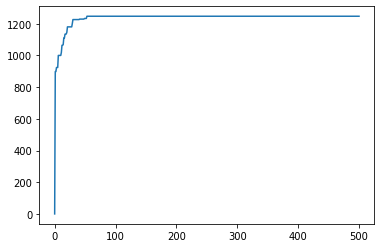

In [12]:
## Hiperparametros del algoritmo genetico
POPSIZE = 50       # numero de individuos
GENERATIONS = 500   # numero de generaciones
PMUT = 0.5       # taza de mutacion

## Inicializa una poblacion inicial de forma aleatoria
poblacion_inicial =  init_population(POPSIZE, NUM_ITEMS)

# Evolue la poblacion con el algoritmo genetico (cruzamiento 'onepoint', )
best_ind, bestfitness = genetic_algorithm(poblacion_inicial, ItemPool, MAX_WEIGHT, GENERATIONS, PMUT, 
                                          crossover="uniform", mutation="flip", 
                                          selection_parents_method = 'roulette', 
                                          selection_survivors_method = 'ranking')

# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()

# Preguntas:

<b>1) Compare el desempeño de los operadores de cruzamiento y seleccion </b> (5 puntos)

<b>Se debe colocar la tasa de mutación = 0</b> (a fin de centrarnos solo en el efecto de cruzamiento) y ejecutar 10 ejecuciones del Algoritmo genético con 50 individuos, 300 generaciones para cada una de las siguientes configuraciones:

- Operador de Cruzamiento onepoint y selección por el metodo de la ruleta
- Operador de Cruzamiento onepoint y selección por el metodo torneo (tamaño del torneo = 3)
- Operador de Cruzamiento uniform y selección por el metodo de la ruleta
- Operador de Cruzamiento uniform y selección por el metodo torneo (tamaño del torneo = 3)

Registre el promedio del fitness máximo obtenido con cada configuración (promedio de 10 valores), asi como el promedio de la generación donde converge el algoritmo (la primera generacion donde se obtiene el fitness máximo). Indique con cual o cuales configuraciones se obtiene mayor fitness y mayor rapidez de convergencia y explique por qué?

In [13]:
## Hiperparametros del algoritmo genetico
POPSIZE = 50       # numero de individuos
GENERATIONS = 300   # numero de generaciones
PMUT = 0       # taza de mutacion
CROSSOVER = ['onepoint','uniform']
SELECTION_PARENTS_METHOD = ['roulette','tournament']

## Inicializa una poblacion inicial de forma aleatoria
poblacion_inicial =  init_population(POPSIZE, NUM_ITEMS)

# Evolue la poblacion con el algoritmo genetico (cruzamiento 'onepoint', )
crossover_fitness = []
crossover_converge_generation = []
j = 0
for CROSS in CROSSOVER:
  for SELECTION in SELECTION_PARENTS_METHOD:
    crossover_fitness.append([])
    crossover_converge_generation.append([])
    for ind in range(10):
      best_ind, bestfitness = genetic_algorithm(poblacion_inicial, ItemPool, MAX_WEIGHT, GENERATIONS, PMUT, 
                                          crossover=CROSS, mutation="flip", 
                                          selection_parents_method = SELECTION, 
                                          selection_survivors_method = 'ranking')
      crossover_fitness[j].append(best_ind.fitness)
      crossover_converge_generation[j].append(bestfitness.index(best_ind.fitness))
    j = j + 1

Poblacion inicial, best_fitness = 587
generacion 0, (Mejor fitness = 662)
generacion 10, (Mejor fitness = 923)
generacion 20, (Mejor fitness = 949)
generacion 30, (Mejor fitness = 949)
generacion 40, (Mejor fitness = 949)
generacion 50, (Mejor fitness = 949)
generacion 60, (Mejor fitness = 949)
generacion 70, (Mejor fitness = 949)
generacion 80, (Mejor fitness = 949)
generacion 90, (Mejor fitness = 949)
generacion 100, (Mejor fitness = 949)
generacion 110, (Mejor fitness = 949)
generacion 120, (Mejor fitness = 949)
generacion 130, (Mejor fitness = 949)
generacion 140, (Mejor fitness = 949)
generacion 150, (Mejor fitness = 949)
generacion 160, (Mejor fitness = 949)
generacion 170, (Mejor fitness = 949)
generacion 180, (Mejor fitness = 949)
generacion 190, (Mejor fitness = 949)
generacion 200, (Mejor fitness = 949)
generacion 210, (Mejor fitness = 949)
generacion 220, (Mejor fitness = 949)
generacion 230, (Mejor fitness = 949)
generacion 240, (Mejor fitness = 949)
generacion 250, (Mejor 

In [14]:
print('one point with roulette')
print('best fitness mean: ', np.array(crossover_fitness[0]).mean())
print('first converge generation mean: ', np.array(crossover_converge_generation[0]).mean())
print('one point with tournament')
print('best fitness mean: ', np.array(crossover_fitness[1]).mean())
print('first converge generation mean: ', np.array(crossover_converge_generation[1]).mean())
print('uniform with roulette')
print('best fitness mean: ', np.array(crossover_fitness[2]).mean())
print('first converge generation mean: ', np.array(crossover_converge_generation[2]).mean())
print('uniform with tournament')
print('best fitness mean: ', np.array(crossover_fitness[3]).mean())
print('first converge generation mean: ', np.array(crossover_converge_generation[3]).mean())

one point with roulette
best fitness mean:  881.8
first converge generation mean:  11.2
one point with tournament
best fitness mean:  948.9
first converge generation mean:  8.2
uniform with roulette
best fitness mean:  1074.9
first converge generation mean:  26.1
uniform with tournament
best fitness mean:  1173.3
first converge generation mean:  18.8


El mejor fitness lo obtuvo con uniform con selección tournament mientras que la primera convergencia lo obtuvo one point con selección tournament. Esto puede deberse a que el torneo trata de elegir entre los mejores fitness mientras que roulette si bien matiene las mejores proporciones aún así el resultado es más aleatorio. Por otro lado la aletoriedad del uniform hizo obtener mejor fitness que one point y es posible que sea por la cantidad de combinaciones posibles que se tenían que explorar por el otro lado one point al ser de un solo corte presenta un grado de orden que permite encontrar un buen fitness en pocas generaciones pero se aleja del fitness óptimo conforme se sigue cortando.

<b>2) Implemente el método <i>mutation_multiflip</i> en la clase Individual</b>

<b>3) Determine la influencia de la mutación </b>

Con el mejor operador de cruzamiento y seleccion identificado en la pregunta 1, ejecute el Algoritmo Genético con 50 individuos, 300 generaciones y las siguientes configuraciones: 

- Operador de Mutación flip y tasa de mutación 5%
- Operador de Mutación flip y tasa de mutación 50%
- Operador de Mutación flip y tasa de mutación 100%
- Operador de Mutación multiflip y tasa de mutación 5%
- Operador de Mutación multiflip y tasa de mutación 50%
- Operador de Mutación multiflip y tasa de mutación 100%

Registre el promedio del fitness máximo obtenido con cada configuración (promedio de 10 valores), asi como el promedio de la generación donde converge el algoritmo (la primera generacion donde se obtiene el fitness máximo). Indique como influye el operador de mutación y la tasa de mutación en los resultados e intente dar una explicación de lo que está pasando. 

In [17]:
## Hiperparametros del algoritmo genetico
POPSIZE = 50       # numero de individuos
GENERATIONS = 300   # numero de generaciones
PMUT = [0.05,0.5,1]       # taza de mutacion
MUTATION = ['flip','multiflip']

## Inicializa una poblacion inicial de forma aleatoria
poblacion_inicial =  init_population(POPSIZE, NUM_ITEMS)

# Evolue la poblacion con el algoritmo genetico (cruzamiento 'onepoint', )
for MUT in MUTATION:
  for M in PMUT:
    crossover_fitness.append([])
    crossover_converge_generation.append([])
    for ind in range(10):
      best_ind, bestfitness = genetic_algorithm(poblacion_inicial, ItemPool, MAX_WEIGHT, GENERATIONS, M, 
                                          crossover="uniform", mutation=MUT, 
                                          selection_parents_method = 'roulette', 
                                          selection_survivors_method = 'ranking')
      crossover_fitness[j].append(best_ind.fitness)
      crossover_converge_generation[j].append(bestfitness.index(best_ind.fitness))
    j = j + 1

Poblacion inicial, best_fitness = 740
generacion 0, (Mejor fitness = 835)
generacion 10, (Mejor fitness = 1007)
generacion 20, (Mejor fitness = 1087)
generacion 30, (Mejor fitness = 1129)
generacion 40, (Mejor fitness = 1136)
generacion 50, (Mejor fitness = 1136)
generacion 60, (Mejor fitness = 1136)
generacion 70, (Mejor fitness = 1136)
generacion 80, (Mejor fitness = 1136)
generacion 90, (Mejor fitness = 1136)
generacion 100, (Mejor fitness = 1136)
generacion 110, (Mejor fitness = 1136)
generacion 120, (Mejor fitness = 1136)
generacion 130, (Mejor fitness = 1136)
generacion 140, (Mejor fitness = 1136)
generacion 150, (Mejor fitness = 1136)
generacion 160, (Mejor fitness = 1136)
generacion 170, (Mejor fitness = 1136)
generacion 180, (Mejor fitness = 1136)
generacion 190, (Mejor fitness = 1136)
generacion 200, (Mejor fitness = 1136)
generacion 210, (Mejor fitness = 1136)
generacion 220, (Mejor fitness = 1136)
generacion 230, (Mejor fitness = 1136)
generacion 240, (Mejor fitness = 1136)

In [18]:
print('mutation flip with pmut = 0.05')
print('best fitness mean: ', np.array(crossover_fitness[0]).mean())
print('first converge generation mean: ', np.array(crossover_converge_generation[0]).mean())
print('mutation flip with pmut = 0.5')
print('best fitness mean: ', np.array(crossover_fitness[1]).mean())
print('first converge generation mean: ', np.array(crossover_converge_generation[1]).mean())
print('mutation flip with pmut = 1')
print('best fitness mean: ', np.array(crossover_fitness[2]).mean())
print('first converge generation mean: ', np.array(crossover_converge_generation[2]).mean())
print('mutation multiflip with pmut = 0.05')
print('best fitness mean: ', np.array(crossover_fitness[3]).mean())
print('first converge generation mean: ', np.array(crossover_converge_generation[3]).mean())
print('mutation multiflip with pmut = 0.5')
print('best fitness mean: ', np.array(crossover_fitness[4]).mean())
print('first converge generation mean: ', np.array(crossover_converge_generation[4]).mean())
print('mutation multiflip with pmut = 1')
print('best fitness mean: ', np.array(crossover_fitness[5]).mean())
print('first converge generation mean: ', np.array(crossover_converge_generation[5]).mean())

mutation flip with pmut = 0.05
best fitness mean:  881.8
first converge generation mean:  11.2
mutation flip with pmut = 0.5
best fitness mean:  948.9
first converge generation mean:  8.2
mutation flip with pmut = 1
best fitness mean:  1074.9
first converge generation mean:  26.1
mutation multiflip with pmut = 0.05
best fitness mean:  1173.3
first converge generation mean:  18.8
mutation multiflip with pmut = 0.5
best fitness mean:  1075.4
first converge generation mean:  47.6
mutation multiflip with pmut = 1
best fitness mean:  1245.8
first converge generation mean:  62.8


El mejor fitness lo obtuvo la mutación multiflip con una tasa de 100% mientras que la primera convergencia lo obtuvo la mutación flip con una tasa de 50%. En este caso multiflip permitió explorar más combinación de hijos por lo que obtuvo un mejor fitness, la aletoriedad de la tasa de 100% puede ser una casualidad que fue a lo mejor también pudiendo haber ido a lo peor que en este caso ayudó debido a la cantidad de combinaciones posibles. Mientras el flip se centra en un alelo obteniendo rápidamente un buen fitness pero faltando más combinaciones para obtener el fitness óptimo en la cantidad de generaciones impuestas.